# Models comparison


Compare several approaches and visualize results.

Parameters meaning and processes of training and evaluation are described in the report in details

In [139]:
import copy
import json
import os
import warnings
from ast import literal_eval
from itertools import product
from typing import Any, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score
from torcheval.metrics.functional.ranking import retrieval_precision
from tqdm import tqdm

In [140]:
MANUAL_SEED = 42
torch.manual_seed(MANUAL_SEED)

warnings.filterwarnings("ignore")

## Functions

### Data loading and preprocessing


In [141]:
def load_dataset(path: str) -> pd.DataFrame:
    loaded_dfs = [
        pd.read_csv(os.path.join(path, file_name)) for file_name in os.listdir(path)
    ]
    return pd.concat(loaded_dfs)


def load_datasets(path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    return load_dataset(os.path.join(path, "train/")), load_dataset(
        os.path.join(path, "test/")
    )

In [142]:
NUM_MOVIES = 1682
BASIC_USER_FEATURES = 3

TOTAL_USER_FEATURES = BASIC_USER_FEATURES + 19

In [143]:
class RecommendationDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.drop(columns=["user_id"])
        features = []
        inputs = []
        targets = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            features.append(
                row[:BASIC_USER_FEATURES].tolist() + literal_eval(row["genres"])
            )
            inputs.append(literal_eval(row["input"]))
            targets.append(literal_eval(row["output"]))

        self.features = np.array(features)

        # normalize ratings
        self.inputs = np.array(inputs) / 5
        self.targets = np.array(targets) / 5

    def __getitem__(self, idx: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        input_ratings = self.inputs[idx]
        input_data = np.concatenate([self.features[idx], input_ratings])
        mask = input_ratings == 0
        return input_data, mask, self.targets[idx]

    def __len__(self) -> int:
        return len(self.df)

In [144]:
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DEVICE

device(type='cuda')

In [145]:
def collate_batch(batch: list) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_data_batch, mask_batch, target_batch = [], [], []
    for input_data, mask, target in batch:
        input_data_batch.append(input_data)
        mask_batch.append(mask)
        target_batch.append(target)

    return (
        torch.Tensor(input_data_batch),
        torch.Tensor(mask_batch).bool(),
        torch.Tensor(target_batch),
    )

### Creating the network


In [146]:
INPUT_SIZE = TOTAL_USER_FEATURES + NUM_MOVIES


class RecSys(nn.Module):
    def __init__(
        self,
        hidden_dim1: int = 1024,
        hidden_dim2: int = 1024,
        hidden_dim3: int = 1024,
    ):
        super(RecSys, self).__init__()

        self.d1 = nn.Dropout(0.1)
        self.d2 = nn.Dropout(0.1)

        self.fc1 = nn.Linear(INPUT_SIZE, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, NUM_MOVIES)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.d1(x)
        x = F.relu(self.fc2(x))
        x = self.d2(x)
        x = F.relu(self.fc3(x))

        return F.sigmoid(self.fc4(x))

In [147]:
def create_model() -> tuple[nn.Module, Any]:
    torch.manual_seed(MANUAL_SEED)
    model = RecSys()

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, optimizer

### Train model


In [148]:
def train_one_epoch(
    model: nn.Module,
    loader,
    optimizer,
    loss_fn,
    epoch,
    use_mask: bool = True,
    loss_type: str = "BCE",
) -> float:
    model.train()
    train_loss = 0.0
    total = 0

    loop = tqdm(
        loader,
        total=len(loader),
        desc=f"Epoch {epoch}: train",
        leave=True,
    )
    for batch in loop:
        input_data, mask, target = batch
        input_data, target, mask = (
            input_data.to(DEVICE),
            target.to(DEVICE),
            mask.to(DEVICE),
        )

        # forward pass and loss calculation
        outputs = model(input_data)

        # zero the parameter gradients
        optimizer.zero_grad()

        relevant_targets = (target > 0).float() if loss_type == "BCE" else target

        if use_mask:
            loss = loss_fn(
                torch.masked_select(outputs, mask),
                torch.masked_select(relevant_targets, mask),
            )
        else:
            loss = loss_fn(outputs, relevant_targets)

        # backward pass
        loss.backward()
        total += target.shape[1]

        # optimizer run
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix({"loss": train_loss / total})
    return train_loss / total


def val_one_epoch(
    model: nn.Module,
    loader,
    loss_fn,
    epoch,
    use_mask: bool = True,
    loss_type: str = "BCE",
) -> float:
    loop = tqdm(
        loader,
        total=len(loader),
        desc=f"Epoch {epoch}: val",
        leave=True,
    )
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        model.eval()  # evaluation mode
        for batch in loop:
            input_data, mask, target = batch
            input_data, target, mask = (
                input_data.to(DEVICE),
                target.to(DEVICE),
                mask.to(DEVICE),
            )

            outputs = model(input_data)

            relevant_targets = (target > 0).float() if loss_type == "BCE" else target

            if use_mask:
                loss = loss_fn(
                    torch.masked_select(outputs, mask),
                    torch.masked_select(relevant_targets, mask),
                )
            else:
                loss = loss_fn(outputs, relevant_targets)

            val_loss += loss.item()
            total += target.shape[1]
            loop.set_postfix({"loss": val_loss / total})
    return val_loss / total

In [149]:
def train_model(
    model: nn.Module,
    optimizer,
    loss_fn,
    train_dataloader,
    val_dataloader,
    save_best_path: str,
    save_latest_path: str,
    num_epochs: int,
    use_mask: bool = True,
    loss_type: str = "BCE",
) -> tuple[nn.Module, list[float], list[float]]:
    best_loss = 1e10
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            epoch,
            use_mask=use_mask,
            loss_type=loss_type,
        )
        val_loss = val_one_epoch(
            model, val_dataloader, loss_fn, epoch, use_mask=use_mask, loss_type=loss_type
        )
        if val_loss <= best_loss:
            best_loss = val_loss
            torch.save(model, save_best_path)

        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
    torch.save(model, save_latest_path)

    return copy.deepcopy(model), train_losses, val_losses

### Test model


In [150]:
def get_single_output(
    model: nn.Module,
    input_data: np.ndarray,
) -> np.ndarray:
    with torch.no_grad():
        model.eval()
        input_tensor = torch.Tensor([input_data]).to(DEVICE)
        model_out = model(input_tensor)

    return model_out[0].cpu().numpy()


def get_unseen_on_input_data(
    input_rating: np.ndarray, movie_ratings: np.ndarray
) -> np.ndarray:
    unseen_ratings = movie_ratings.copy()
    seen_indices = np.nonzero(input_rating > 0)[0]
    unseen_ratings[seen_indices] = 0
    return unseen_ratings

### Metrics

In [154]:
def generate_test_data(
    model: nn.Module, dataset: RecommendationDataset
) -> list[tuple[np.ndarray, np.ndarray]]:
    test_data = []

    for input_data, _, target in tqdm(dataset):
        predicted = get_single_output(model, input_data)

        input_ratings = input_data[TOTAL_USER_FEATURES:]
        unseen_predicted = get_unseen_on_input_data(input_ratings, predicted)
        unseen_target = get_unseen_on_input_data(input_ratings, target)
        test_data.append((unseen_target, unseen_predicted))

    return test_data

In [155]:
def get_top_args(x: np.ndarray, n: int) -> np.ndarray:
    return np.argsort(-x)[:n]


def top_intersection(target: np.ndarray, predicted: np.ndarray, top_n: int = 20):
    return list(
        set(get_top_args(target, top_n)).intersection(get_top_args(predicted, top_n))
    )


def top_k_intersections(
    data: list[tuple[np.ndarray, np.ndarray]], k: int, threshold: float = 0.0
) -> list[int]:
    intersections = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target[unseen_target > threshold]
        relevant_predicted = unseen_predicted[unseen_predicted > threshold]
        intersections.append(
            len(top_intersection(nonzero_targets, relevant_predicted, k))
        )

    return intersections


def retrieval_precisions_on_k(
    data: list[tuple[np.ndarray, np.ndarray]], k: int, threshold: float = 0.0
) -> list[int]:
    retrieval_precisions = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        relevant_predicted = unseen_predicted

        retrieval_precisions.append(
            retrieval_precision(
                torch.Tensor(relevant_predicted), torch.Tensor(nonzero_targets), k
            )
        )

    return retrieval_precisions


def precision_scores(
    data: list[tuple[np.ndarray, np.ndarray]], threshold: float = 0.0
) -> list[int]:
    precisions = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        relevant_predicted = unseen_predicted > threshold

        precisions.append(precision_score(relevant_predicted, nonzero_targets))

    return precisions


def recall_scores(
    data: list[tuple[np.ndarray, np.ndarray]], threshold: float = 0.0
) -> list[int]:
    recalls = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        relevant_predicted = unseen_predicted > threshold

        recalls.append(recall_score(relevant_predicted, nonzero_targets))

    return recalls


def average_precision_on_k(target: np.ndarray, predicted: np.ndarray, k: int) -> float:
    relevant_predicted = predicted.copy()
    if len(relevant_predicted) > k:
        relevant_predicted = relevant_predicted[:k]

    score = 0.0
    hits = 0

    for idx, x in enumerate(relevant_predicted):
        if x in target and x not in relevant_predicted[:idx]:
            hits += 1
            score += hits / (idx + 1.0)

    return score / max(min(len(target), k), 1)


def map_on_k(targets: list[np.ndarray], predictions: list[np.ndarray], k: int) -> float:
    return np.mean(
        [
            average_precision_on_k(target, predicted, k)
            for target, predicted in zip(targets, predictions)
        ]
    )


def generate_total_data_lists(
    data: list[tuple[np.ndarray, np.ndarray]], threshold: float = 0.0
) -> tuple[list[np.ndarray], list[np.ndarray]]:
    all_targets = []
    all_predictions = []
    for unseen_target, unseen_predicted in data:
        nonzero_targets = unseen_target > threshold
        all_targets.append(
            np.argsort(nonzero_targets)[len(nonzero_targets) - sum(nonzero_targets) :]
        )
        all_predictions.append(np.argsort(-unseen_predicted))

    return all_targets, all_predictions

In [156]:
def get_metrics_dict(
    data: list[tuple[np.ndarray, np.ndarray]], ks: list[int], threshold: float = 0.0
) -> dict:
    all_targets, all_predictions = generate_total_data_lists(data, threshold=threshold)
    precisions = precision_scores(data, threshold=threshold)
    recalls = recall_scores(data, threshold=threshold)
    metrics_dict: dict[str, Any] = {
        "global": {
            "mean_precision": float(np.mean(precisions)),
            "mean_recalls": float(np.mean(recalls)),
        }
    }
    for k in ks:
        intersections = top_k_intersections(data, k, threshold=threshold)
        retrieval_precisions = retrieval_precisions_on_k(data, k, threshold=threshold)
        map_score = map_on_k(all_targets, all_predictions, k)

        metrics_dict[str(k)] = {
            "mean_top_intersections": float(np.mean(intersections)),
            "mean_retrieval_precision": float(np.mean(retrieval_precisions)),
            "map": float(map_score),
        }
    return metrics_dict

In [157]:
def show_dict_metrics(models_dict: dict):
    for model_name, values in models_dict.items():
        metrics_dict = values["metrics"]
        print(f"{model_name.upper()}")
        for k_value, metrics in metrics_dict.items():
            print(f"K={k_value}")
            for k, v in metrics.items():
                print(f"{k}: {v}")
        print()

## Comparison

## Build required sets

In [158]:
def build_dataset(path: str) -> RecommendationDataset:
    df = load_dataset(path)
    return RecommendationDataset(df)


def build_datasets(path: str) -> tuple[RecommendationDataset, RecommendationDataset]:
    data_frames = load_datasets(path)
    return (
        RecommendationDataset(data_frames[0]),
        RecommendationDataset(data_frames[1]),
    )

In [159]:
NUM_EPOCHS = 10
METRICS_KS = [5, 10, 20, 50]


def start_comparison(parameters_iterator, save_model_path: str = "../models/") -> dict:
    models_dict = {}
    prev_data_name = ""
    prev_data = (0, 0)

    for (data_name, data_path), (loss_name, loss_fn), loss_mask in parameters_iterator:
        model_name = f"{loss_name.lower()}_{data_name}{'_m' if loss_mask else ''}"
        print(model_name.upper())

        # Data loading
        if data_name == prev_data_name:
            data = prev_data
        else:
            prev_data_name = data_name
            data = prev_data = build_datasets(data_path)

        train_dataset, val_dataset = data

        torch.cuda.empty_cache()
        train_dataloader = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_batch,
        )
        val_dataloader = torch.utils.data.DataLoader(
            dataset=val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_batch,
        )

        # Train
        model_name_best = f"{model_name}_best"
        model_path_best = os.path.join(save_model_path, model_name_best)

        model_name_latest = f"{model_name}_latest"
        model_path_latest = os.path.join(save_model_path, model_name_latest)

        model, optimizer = create_model()
        _best, train_losses, val_losses = train_model(
            model,
            optimizer,
            loss_fn,
            train_dataloader,
            val_dataloader,
            model_path_best,
            model_path_latest,
            NUM_EPOCHS,
            use_mask=loss_mask,
            loss_type=loss_name,
        )

        # Test
        for name, load_path in zip(
            [model_name_best, model_name_latest], [model_path_best, model_path_latest]
        ):
            model = torch.load(load_path)
            model.eval()

            test_data = generate_test_data(model, val_dataset)
            metrics_dict = get_metrics_dict(test_data, METRICS_KS)

            models_dict[name] = {
                "metrics": metrics_dict,
                "train_losses": train_losses,
                "val_losses": val_losses,
            }
        print()

    return models_dict

In [160]:
data_set = [
    ("msplit", "../data/interim/masks_split/"),
    ("usplit", "../data/interim/users_split/"),
]
loss_fn_set = [("BCE", torch.nn.BCELoss()), ("MSE", torch.nn.MSELoss())]
loss_mask_set = [True, False]

parameters_iterator = product(data_set, loss_fn_set, loss_mask_set)

In [161]:
models_dict = start_comparison(parameters_iterator)

BCE_MSPLIT_M


100%|██████████| 1886/1886 [00:02<00:00, 796.79it/s] 



BCE_MSPLIT


100%|██████████| 1886/1886 [00:02<00:00, 835.25it/s] 



MSE_MSPLIT_M


100%|██████████| 1886/1886 [00:03<00:00, 529.96it/s]



MSE_MSPLIT


100%|██████████| 1886/1886 [00:02<00:00, 935.10it/s]



BCE_USPLIT_M


100%|██████████| 1900/1900 [00:01<00:00, 986.55it/s]



BCE_USPLIT


100%|██████████| 1900/1900 [00:01<00:00, 964.49it/s] 



MSE_USPLIT_M


100%|██████████| 1900/1900 [00:02<00:00, 945.88it/s]



MSE_USPLIT


100%|██████████| 1900/1900 [00:01<00:00, 954.77it/s]


In [162]:
show_dict_metrics(models_dict)

BCE_MSPLIT_M_BEST
K=global
mean_precision: 1.0
mean_recalls: 0.0544221513080744
K=5
mean_top_intersections: 0.07264050901378578
mean_retrieval_precision: 0.8098621368408203
map: 0.7675715800636267
K=10
mean_top_intersections: 0.25715800636267233
mean_retrieval_precision: 0.7588017582893372
map: 0.6965394342608022
K=20
mean_top_intersections: 0.9220572640509014
mean_retrieval_precision: 0.696474015712738
map: 0.621724426010414
K=50
mean_top_intersections: 4.080593849416755
mean_retrieval_precision: 0.5842629671096802
map: 0.574159653201834

BCE_MSPLIT_M_LATEST
K=global
mean_precision: 1.0
mean_recalls: 0.0544221513080744
K=5
mean_top_intersections: 0.07264050901378578
mean_retrieval_precision: 0.8098621368408203
map: 0.7675715800636267
K=10
mean_top_intersections: 0.25715800636267233
mean_retrieval_precision: 0.7588017582893372
map: 0.6965394342608022
K=20
mean_top_intersections: 0.9220572640509014
mean_retrieval_precision: 0.696474015712738
map: 0.621724426010414
K=50
mean_top_intersec

### Save models info

In [163]:
with open("../data/interim/models_info.json", "w") as f:
    json.dump(models_dict, f, indent=4)

## Visualize


In [170]:
PREDEFINED_COLORS = [
    "#ff0000",
    "#ffd700",
    "#00ff00",
    "#04eafc",
    "#071efb",
    "#9603fd",
]


def gen_colors(num_colors: int, use_rainbow: bool) -> list:
    if use_rainbow and len(PREDEFINED_COLORS) >= num_colors:
        return PREDEFINED_COLORS
    cm = plt.get_cmap("gist_rainbow")
    return list(reversed([cm(1.0 * i / num_colors) for i in range(num_colors)]))


def draw_metrics_plots(
    models_dict: dict,
    metrics_to_compare: list[str] = ["mean_retrieval_precision", "map"],
    figsize=(14, 18),
    use_rainbow: bool = True,
    save_path: Optional[str] = None,
):
    num_colors = len(models_dict)
    colors = gen_colors(num_colors, use_rainbow)

    postfix = "_best"
    postfix_len = len(postfix)
    bce_models = list(
        filter(lambda x: x.startswith("bce") and x.endswith(postfix), models_dict.keys())
    )
    mse_models = list(
        filter(lambda x: x.startswith("mse") and x.endswith(postfix), models_dict.keys())
    )

    epochs = list(range(1, len(models_dict[bce_models[0]]["train_losses"]) + 1))
    k_values = list(
        filter(lambda x: x != "global", models_dict[bce_models[0]]["metrics"].keys())
    )

    total_plots = 4 + len(k_values) * len(metrics_to_compare)
    columns = 2

    fig, axs = plt.subplots(total_plots // columns, columns, figsize=figsize)
    ax1, ax2, ax3, ax4, *rest_axs = axs.flat

    ax1.set_title("Training loss | BCE")
    ax2.set_title("Validation loss | BCE")
    ax3.set_title("Training loss | MSE")
    ax4.set_title("Validation loss | MSE")

    for ax in axs.flat:
        ax.grid()
        ax.set_prop_cycle(color=colors)

    for ax in (ax1, ax2):
        ax.set(xlabel="Epoch", ylabel="Loss")
        ax.set_prop_cycle(color=gen_colors(len(bce_models), True))

    for ax in (ax3, ax4):
        ax.set(xlabel="Epoch", ylabel="Loss")
        ax.set_prop_cycle(color=gen_colors(len(mse_models), True))

    for model_name in bce_models:
        train_losses, val_losses = (
            models_dict[model_name]["train_losses"],
            models_dict[model_name]["val_losses"],
        )
        ax1.plot(epochs, train_losses, label=model_name[:-postfix_len])
        ax2.plot(epochs, val_losses, label=model_name[:-postfix_len])

    for model_name in mse_models:
        train_losses, val_losses = (
            models_dict[model_name]["train_losses"],
            models_dict[model_name]["val_losses"],
        )
        ax3.plot(epochs, train_losses, label=model_name[:-postfix_len])
        ax4.plot(epochs, val_losses, label=model_name[:-postfix_len])

    for (k, metric), ax in zip(product(k_values, metrics_to_compare), rest_axs):
        names = []
        values = []
        for model_name, metrics_dict in models_dict.items():
            names.append(model_name)
            values.append(metrics_dict["metrics"][k][metric])
        ax.set_title(f"{metric} | K={k}")
        ax.bar(names, values, color=colors, label=names)
        ax.get_xaxis().set_visible(False)

    for ax in (ax1, ax2, ax3, ax4):
        ax.legend()

    lines_labels = [ax.get_legend_handles_labels() for ax in rest_axs[:1]]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]
    fig.legend(
        lines, labels, loc="outside lower center", ncol=6, bbox_to_anchor=(0.5, -0.05)
    )

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "comparison.png"), bbox_inches="tight")

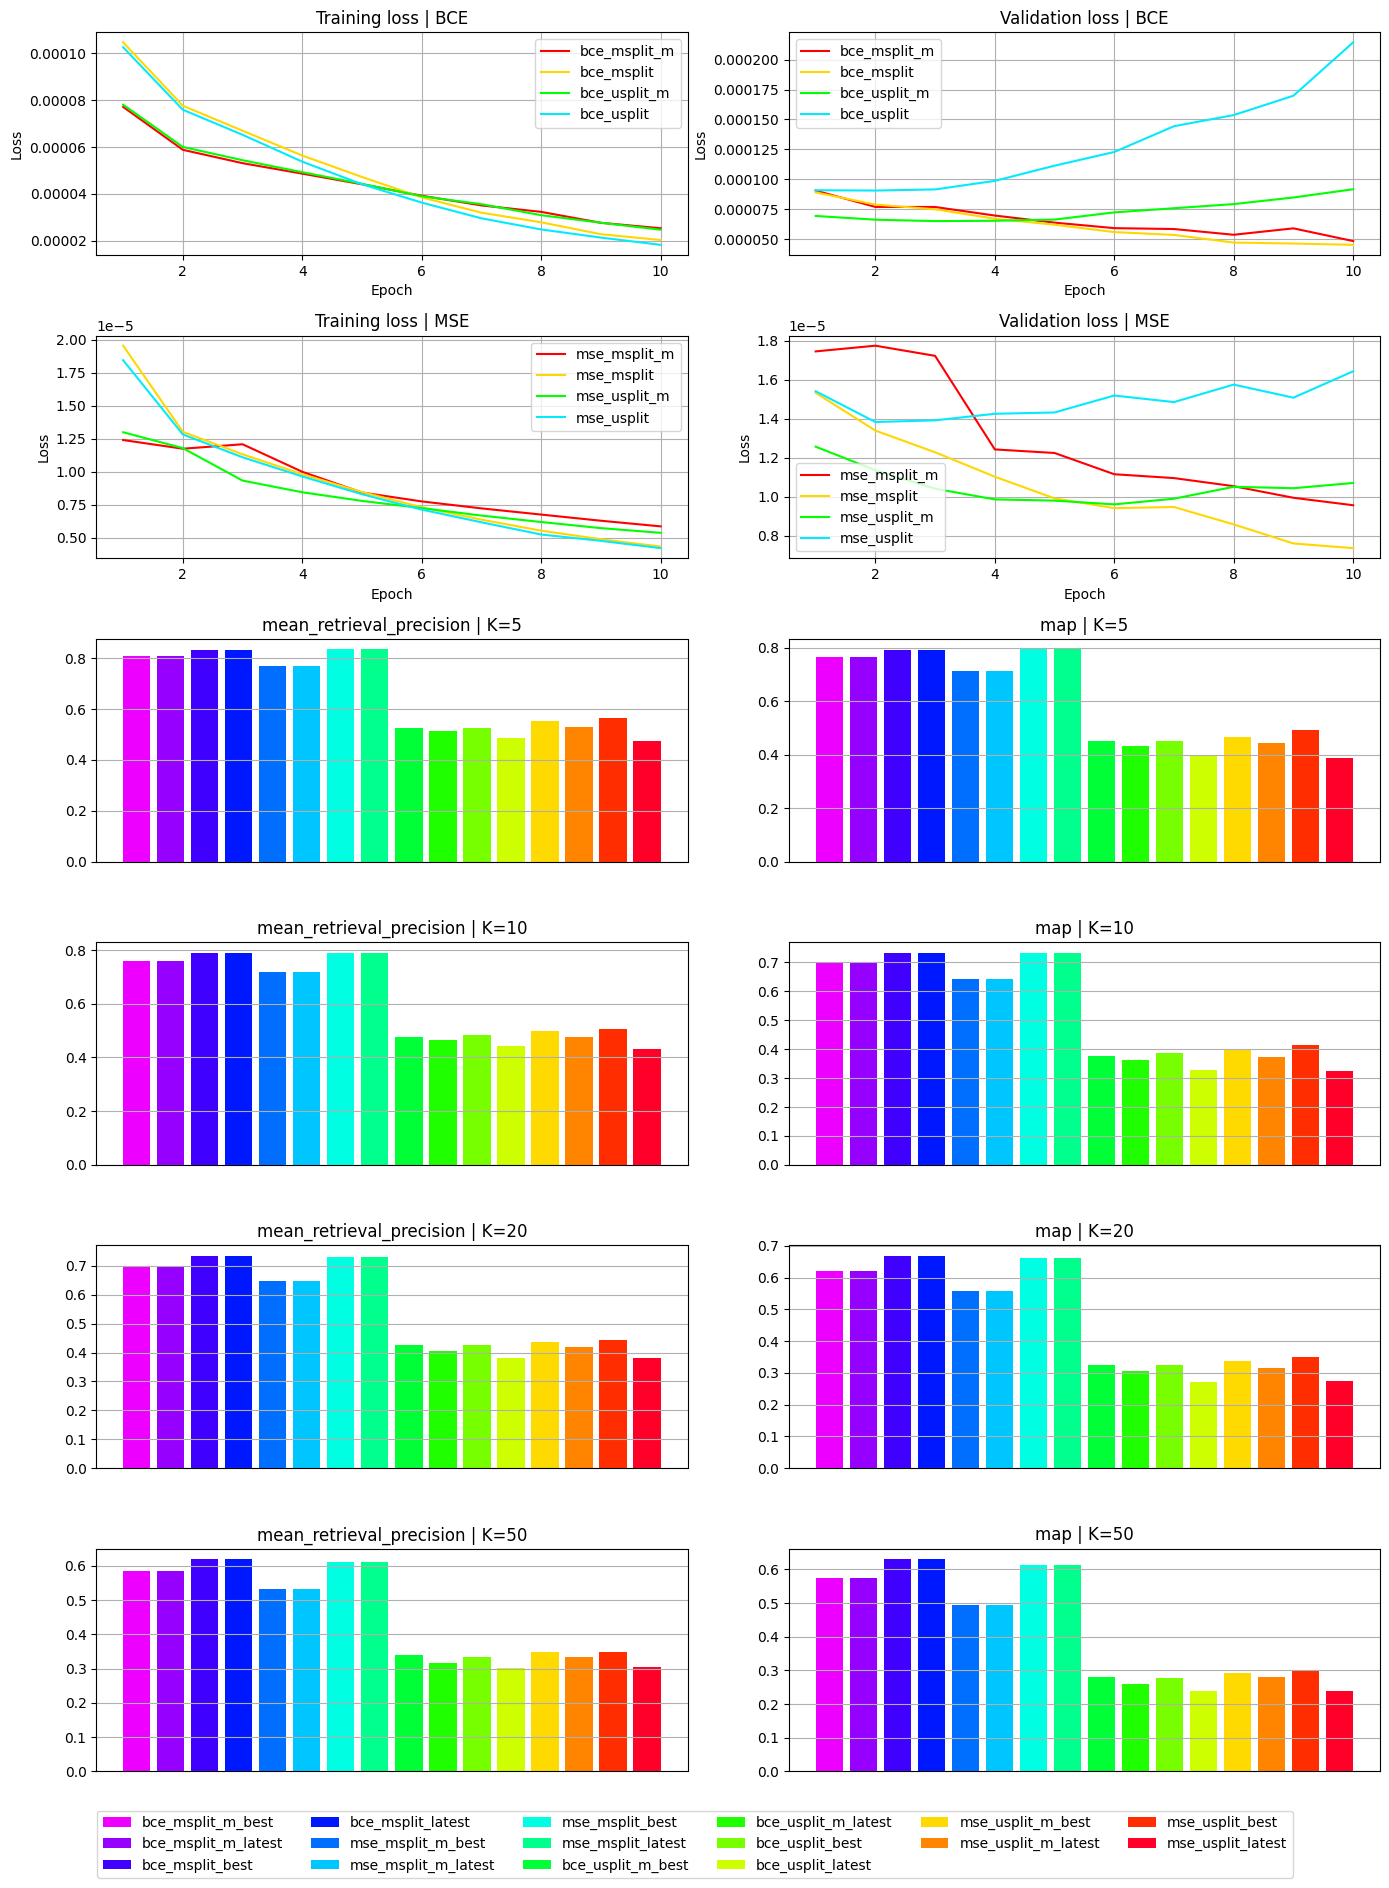

In [171]:
draw_metrics_plots(models_dict, save_path="../data/interim/")

## [DEV] Rebuild info dict

In [ ]:
test_masks_split_df = build_dataset("../data/interim/masks_split/test/")
test_users_split_df = build_dataset("../data/interim/users_split/test/")

100%|██████████| 1900/1900 [00:16<00:00, 115.53it/s]


In [ ]:
def try_another_threshold(models_dict: dict) -> dict:
    new_models_dict = models_dict.copy()
    threshold = 0.5

    def choose_test_data(model_name: str) -> RecommendationDataset:
        if model_name.find("users_split") != -1:
            return test_users_split_df
        return test_masks_split_df

    for model_name in new_models_dict:
        print(model_name.upper())
        model = torch.load(os.path.join("../models/", model_name))
        model.eval()

        test_data = generate_test_data(model, choose_test_data(model_name))
        metrics_dict = get_metrics_dict(test_data, METRICS_KS, threshold=threshold)

        new_models_dict[model_name]["metrics"] = metrics_dict
    return new_models_dict